This notebook implements and tests the method in paper: "Predicting behavior through dynamic modes in resting-state fMRI data"

First load the HCP1200 data from Megatrawl data

In [13]:
import os
from src.CONSTANTS import CONSTANTS
import numpy as np

parcel = 50
n_sub = 1003
trial_length = 1200
trial = 0  # There are 4 trials (0 to 3)
dt = 0.72  # Temporal resolution


subjectIDs = np.loadtxt(os.path.join(CONSTANTS.HOME, "subjectIDs.txt"))
print(f"Total subjects:{len(subjectIDs)}")
fmri_signal = np.zeros((min(n_sub, len(subjectIDs)), parcel, trial_length), dtype=float)

for i, s in enumerate(subjectIDs):
    if i >= n_sub:
        break
    fmri_signal[i] = np.loadtxt(
        os.path.join(CONSTANTS.HOME,
                     "node_timeseries",
                     f"3T_HCP1200_MSMAll_d{parcel}_ts2",
                     f"{int(s)}.txt"))[trial*trial_length:(trial+1) * trial_length].T
fmri_signal = (fmri_signal - fmri_signal.mean(axis=-1)[:, :, np.newaxis]) \
              / fmri_signal.std(axis=-1)[:, :, np.newaxis]

Total subjects:1003


In [14]:
fmri_signal.shape

(1003, 50, 1200)

Select the first subject and create a augmented hankel matrix (See section 2.3)

In [15]:
def createHankelMatrix2D(X, winSize):
    H = np.zeros((X.shape[0] * winSize, X.shape[1] - winSize + 1))
    for i in range(winSize, X.shape[1]):
        H[:, i-winSize] = X[:, i-winSize: i].flatten()
    return H

In [16]:
X = fmri_signal[4, :, 0:256]
winsize = 32
X_aug = createHankelMatrix2D(X, winsize)
print(X_aug.shape)
x = np.arange(0, len(X))
t = np.arange(0, X_aug.shape[1]) * dt

(1600, 225)


Apply DMD

In [17]:
from pydmd import DMD
svd_rank = 16
dmd = DMD(svd_rank=svd_rank)
dmd.fit(X_aug)

/Users/mturja/PycharmProjects/KVAE/tbd-venv/lib/python3.9/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number inf. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


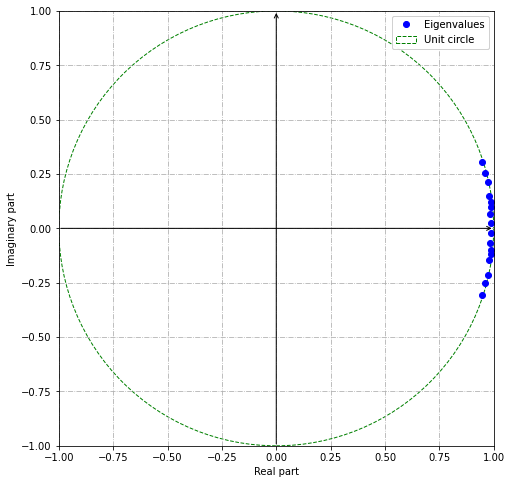

In [18]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [19]:
print(dmd.modes.shape)

(1600, 16)


The size of the DMD modes is 1600 because we stacked 32 time points (32 * 50 = 1600) together. We just need the first 50 values which is the activation of current time point.

In [20]:
modes = dmd.modes.reshape(50, winsize, -1)[:, 0]

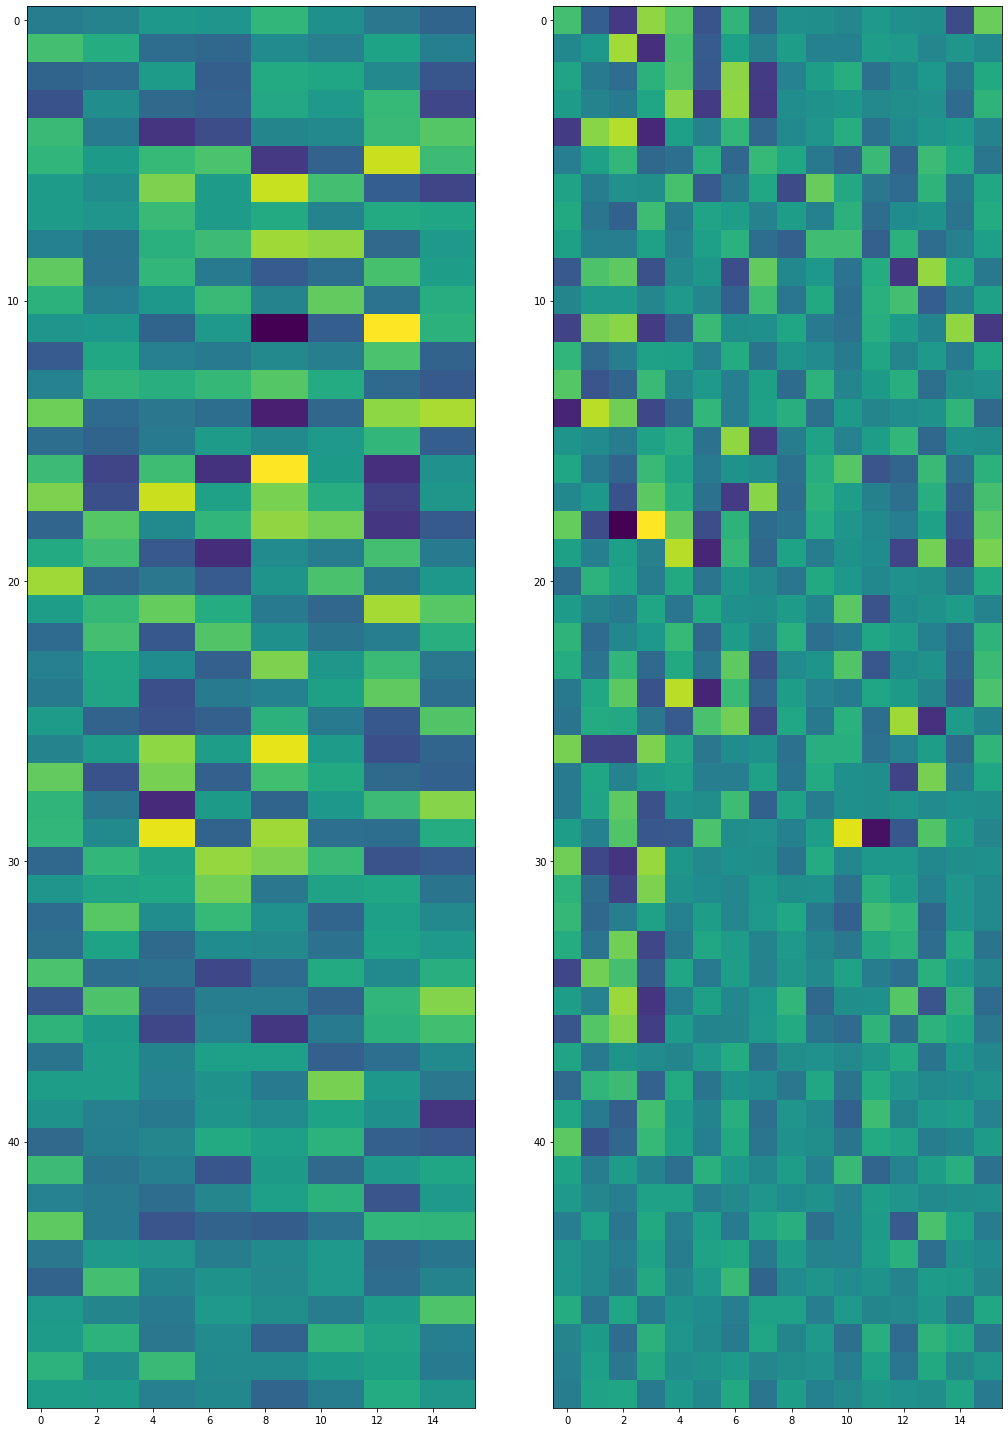

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 20))
plt.subplot(1, 2, 1)
plt.imshow(modes.real)
plt.subplot(1, 2, 2)
plt.imshow(modes.imag)
plt.tight_layout()
plt.show()

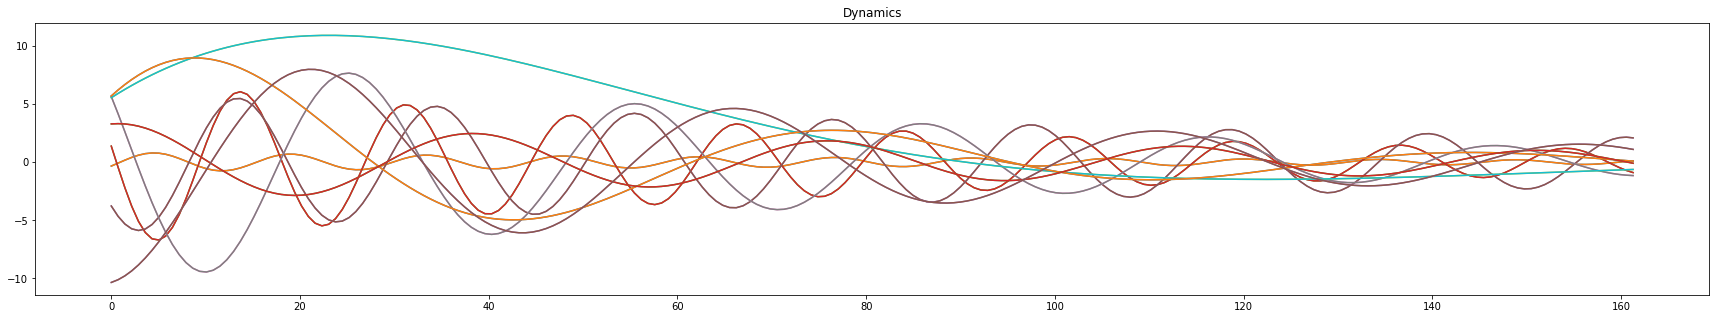

In [22]:
plt.figure(figsize=(30, 5))
for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()

Now plot reconstructed data along with original data

In [23]:
recon = dmd.reconstructed_data.reshape(50, winsize, -1)[:, 0]
print(recon.shape)

(50, 225)


Plot the first 10 nodes

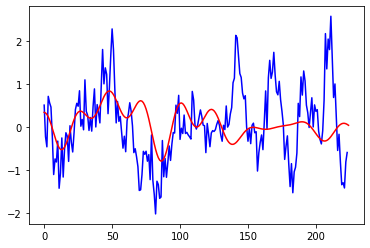

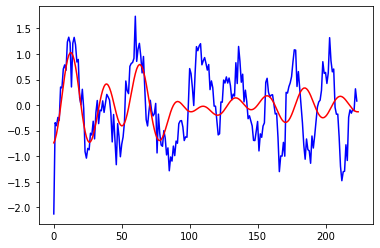

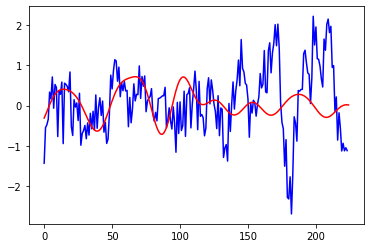

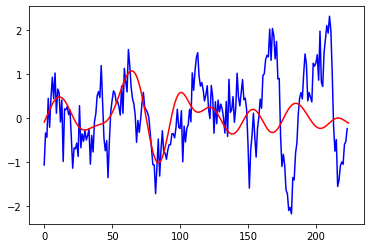

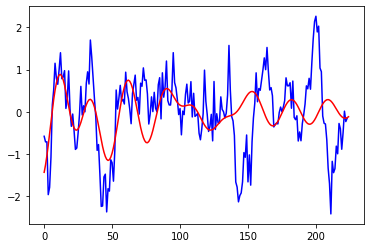

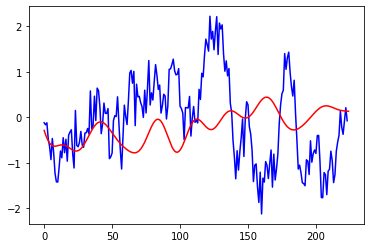

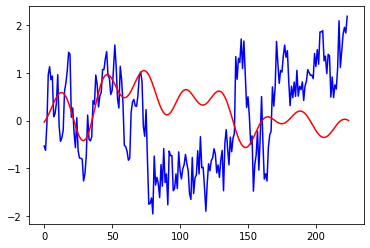

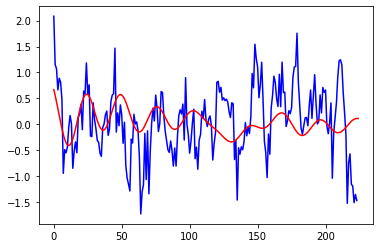

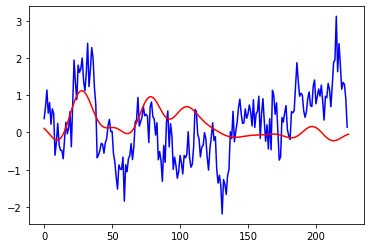

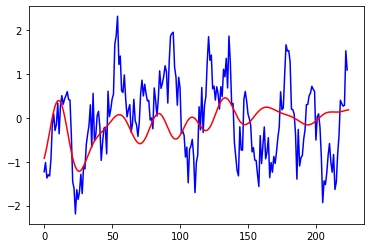

In [24]:
for i in range(10):
    plt.plot(X[i, :-winsize], c='b')
    plt.plot(recon[i].real, c='r')
    plt.show()